In [471]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import statsmodels.api as sm

sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')
from sklearn.model_selection import train_test_split

In [472]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [473]:
sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('talk')
sns.set_style('white')

In [474]:

ppallete = 'RdYlGn'#'YlGn_d' #"BuGn_d"
porder = ['MED4',  'MIT9312','MIT0604', 'Natl2A', 'MIT9313']
ppallete = [ '#62A586', '#face6e','#f79934', '#7A9BC8', '#F47681', ]
psizes = [150,120,200,120,350]
pmarkers = ['o', 's', '^', 'D', '*']

# #ffd7a1
    
pedge = 'green'
apallete = "spring"
aorder = ['DE', 'DE1', '1A3', 'ATCC', 'BS11']
amarkers = ['P', 'X', 'h', '<','>']
apallete = ['#6dad36', '#c7e89f', '#f5c4e1', '#d5579d', '#8a0850']

aedge='orange'
epallete = ['#6cf0ba', '#d13f75', '#eeb7cb', '#b9d2d8', '#407f90']
#sns.diverging_palette(355, 217, s=74, l=50, n=4) #'Paired' # 'BrBG'# "coolwarm"
eorder = ['e1','e3', 'e4', 'e5', 'e6']
#aedge='orange'


In [475]:
from sympy import *

In [476]:
df = pd.read_pickle('CCPA.pkl.gz')
df.loc[df.PRO == 'C9B', 'PRO'] = 'MIT0604'

In [477]:
fcm_data_dpath = r'fcm_and_fl'
fcm_csv_fnames = [ n for n in os.listdir(fcm_data_dpath) if n.endswith('.csv')]
def _load_fcm_fl_csv(data_dpath, fname):
    df = pd.read_csv(os.path.join(data_dpath, fname), index_col=0, header=None).T
    #df = df.reset_index()
    # remove rows and columns that are all nan
    df = df.dropna(how='all')
    df = df.loc[:, df.columns.notnull()] 
    df['Sample'] = os.path.splitext(fname)[0]
    df.VALUE = pd.to_numeric(df.VALUE)
    df.day = pd.to_numeric(df.day)
    df['MODE'] = df.EXP.str.split('_', expand=True)[1]
    #df = df.melt(id_vars=[ 'Sample', 'PRO', 'ALT', 'EXP', 'METHOD','day'],
        #value_vars=['N', 'P', 'TMM', 'N+P+TMM', 'Control ', 'Transfer to Pro99 1:15'],
        #value_name='FL',
        #var_name ='Mode'
    #            )
    return df
fcm_temp_dfs = [_load_fcm_fl_csv(fcm_data_dpath, fname) for fname in fcm_csv_fnames]
fcm_df = pd.concat(fcm_temp_dfs)
#df.loc[df.FL < 100, 'FL'] = 0
fcm_df.loc[fcm_df['MODE']== 'PRO99','MODE'] = 'pro99'
fcm_df.loc[fcm_df.Sample == '9313 LD_FL1', 'PRO'] = 'MIT9313'

In [478]:
fcm_dfn = fcm_df.loc[fcm_df.MODE.isin(['lowN']) & fcm_df.METHOD.isin(['FCM'])]

In [479]:
fcm_dfn.PRO.value_counts()


MED4       48
MIT9313    36
MIT9312    24
Name: PRO, dtype: int64

In [480]:
reference_days = fcm_dfn.loc[fcm_dfn.PRO== 'MIT9313'].day.unique().tolist()

In [481]:
max(reference_days)

34.0

In [482]:
import model.basic_model_lib

In [483]:
m = model.basic_model_lib.ModelProALT()

In [484]:
m.print_param_values()

gamma_n_p 0.04
gamma_c_p 0.04
gamma_n_a 0.04
gamma_c_a 0.04
excretion_n_p 0.01
excretion_c_p 0.01
excretion_n_a 0.01
excretion_c_a 0.01
v_n_max_p 1.9e-09
v_c_max_p 8e-09
v_n_max_a 1.9e-09
v_c_max_a 8e-09
mu_inf_p 0.86
mu_inf_a 0.86
k_n_p 0.11008885160313818
k_c_p 0.11008885160313818
k_n_a 0.11008885160313818
k_c_a 0.11008885160313818
q_n_min_p 7e-10
q_c_min_p 3e-11
q_n_min_a 7e-10
q_c_min_a 3e-11
q_n_max_p 1.5e-09
q_c_max_p 6e-09
q_n_max_a 1.5e-09
q_c_max_a 6e-09
mortality_p 0.1
mortality_a 0.1
r0_p 0.18
r0_a 0.18
b_p 0.01
b_a 0.01
delta_t 1.1574074074074073e-05


In [486]:
param_values = [1.9e-09, 0.86, 0.11, 7e-10,1.5e-09]
param_names = [
'v_n_max_p',
'mu_inf_p', 
'k_n_p' ,
'q_n_min_p' ,
'q_n_max_p' ,
]
ref_df =  fcm_dfn.loc[fcm_dfn.PRO== 'MIT9313']
m = model.basic_model_lib.ModelProALT()
m.disable_organism('ALT')
m.override_initial_values({
    'b_n_a': 0,
    'b_c_a': 0,
    'x_a': 0,
})
m.override_param_values({i : k for i, k in zip(param_names, param_values)})
reference_days = ref_df['day'].unique().tolist()
max_day = int(ref_df['day'].max()) + 1
m.set_referece_times(reference_days)
_, ref_res = m.simulate(num_iterations=max_day*3600*24, collect_every=None)
ref_res_df = pd.DataFrame(ref_res)
t = pd.merge(ref_res_df[['day', 'x_p']], ref_df[['day', 'VALUE']], on='day')
#print(t)
#if np.isfinite(t).any().any() or t.isna().any().any() or (t.shape[0] == 0):


.

In [491]:
(~np.isfinite(t)).any().any()

False

In [533]:
fcm_dfn.loc[fcm_dfn.PRO== 'MIT9313']

,day,VALUE,EXP,METHOD,PRO,ALT,Sample,MODE
1,8.0,2.115254e+06,9313_lowN_1,FCM,MIT9313,NaN,9313 lowN_FCM1,lowN
2,11.0,4.784504e+06,9313_lowN_1,FCM,MIT9313,NaN,9313 lowN_FCM1,lowN
3,13.0,1.158547e+07,9313_lowN_1,FCM,MIT9313,NaN,9313 lowN_FCM1,lowN
4,15.0,2.935981e+07,9313_lowN_1,FCM,MIT9313,NaN,9313 lowN_FCM1,lowN
5,18.0,4.145666e+07,9313_lowN_1,FCM,MIT9313,NaN,9313 lowN_FCM1,lowN
6,20.0,3.365617e+07,9313_lowN_1,FCM,MIT9313,NaN,9313 lowN_FCM1,lowN
7,22.0,2.762228e+07,9313_lowN_1,FCM,MIT9313,NaN,9313 lowN_FCM1,lowN
8,25.0,2.921065e+06,9313_lowN_1,FCM,MIT9313,NaN,9313 lowN_FCM1,lowN
9,28.0,1.468281e+06,9313_lowN_1,FCM,MIT9313,NaN,9313 lowN_FCM1,lowN
10,29.0,7.360775e+04,9313_lowN_1,FCM,MIT9313,NaN,9313 lowN_FCM1,lowN


In [493]:
param_values = [1.9e-09, 0.86, 0.11, 7e-10,1.5e-09]
param_names = [
'v_n_max_p',
'mu_inf_p', 
'k_n_p' ,
'q_n_min_p' ,
'q_n_max_p' ,
]

model.basic_model_lib.model_optimize_PRO(param_values, fcm_dfn.loc[fcm_dfn.PRO== 'MIT9313'], param_names)


.

80.54656675913363

In [494]:
from scipy.optimize import differential_evolution
opt_func = lambda x : model.basic_model_lib.model_optimize_PRO(x, fcm_dfn.loc[fcm_dfn.PRO== 'MIT9313'], param_names)
def compute_bounds(i):
    if i < 0.1:
        return (0, 0.2)
    else:
        return (i/10, i*2)
    
bounds = [compute_bounds(i) for i in param_values]
result = differential_evolution(opt_func, bounds, disp=True)


..

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.....................

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.................................................................

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.....................

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.....................................

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
..differential_evolution step 1: f(x)= 21.0254
..........................................

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
....

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
................

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.............differential_evolution step 2: f(x)= 21.0193
..........................

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.......

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


..........................................

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
differential_evolution step 3: f(x)= 21.0019
..........................

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
..

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
...........................

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
........

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
...........differential_evolution step 4: f(x)= 21.0019
............

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.......

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
......................

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
......

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
....

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
...............

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.....

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
....differential_evolution step 5: f(x)= 21.0019
....

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.............................

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
................

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
..................

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.......

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.differential_evolution step 6: f(x)= 21.0019
.......

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
........

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.....................

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
..............

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.........

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
..

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.........

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.....differential_evolution step 7: f(x)= 21.0019
...........

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
..............

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
........

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
..................

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
........

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
..

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.............differential_evolution step 8: f(x)= 21.0019
.........

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
....................................................

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.......

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.......differential_evolution step 9: f(x)= 21.0019
.

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.....

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.......

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
..............................

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.........

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
......................

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
differential_evolution step 10: f(x)= 20.9977
.....

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
..

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.................

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
..

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.....

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.................

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
..............

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.............

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
differential_evolution step 11: f(x)= 20.9977
.........

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
....

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
........

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
...........

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.............

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
....

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
....

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
......

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
....

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.......

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
..differential_evolution step 12: f(x)= 20.9977
...

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
....

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
...

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
............

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
..

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.......

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
....

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
..

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
..........

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
...

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
........

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.................differential_evolution step 13: f(x)= 20.9977
................

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
....

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
....

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
........

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
..........

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
...............

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.................differential_evolution step 14: f(x)= 20.9977
.....

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.......

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
....

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.....

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
...............

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
......

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
...........

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
....

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.....

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
...

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
..

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.....

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
...differential_evolution step 15: f(x)= 20.9977
....

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


..

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.................

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
....

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.............................

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
...................differential_evolution step 16: f(x)= 20.9977
..

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
....

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.....

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
..

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
....................

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
..

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
........

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
..............

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
................

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
..differential_evolution step 17: f(x)= 20.9977
....

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
..

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
..............

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
..

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
..............

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.....

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
......

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
...

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
..

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.....

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.......

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
........

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.differential_evolution step 18: f(x)= 20.9977
........

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.....................

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
....................

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
......

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
...

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.....

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
...

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
........differential_evolution step 19: f(x)= 20.9977
.......

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
......

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.....

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
..

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
..........

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
....

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.......

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.........

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
...

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
....

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
..................

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
differential_evolution step 20: f(x)= 20.9977
....

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
..

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
............

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.....

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
..............

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
......

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


..

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.........

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
..

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
................

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
..differential_evolution step 21: f(x)= 20.9977
...............

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
...................

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
....

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
......

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
............

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
...................differential_evolution step 22: f(x)= 20.9971
.......................

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.............

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.........

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.................

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


bad
.............differential_evolution step 23: f(x)= 20.997
................................................

In [495]:
result

     fun: 20.99685520996328
     jac: array([-1.31816336e-02, -1.76036963e-03, -7.46069873e-06,  2.29892549e-02,
        1.20969901e-02])
 message: 'Optimization terminated successfully.'
    nfev: 1848
     nit: 23
 success: True
       x: array([0.14239125, 1.13288124, 0.09269998, 0.06018957, 0.06296634])

In [496]:
result.message

'Optimization terminated successfully.'

In [497]:
new_param_values = result.x

In [498]:
m = model.basic_model_lib.ModelProALT()

In [499]:
m.disable_organism('ALT')
m.override_initial_values({
'b_n_a': 0, 
'b_c_a': 0,
'x_a' : 0,
})


In [500]:
m.set_referece_times(reference_days)

In [501]:
m.override_param_values({i:k for i,k in zip(param_names, new_param_values)})

In [534]:
{i:k for i,k in zip(param_names, new_param_values)}

{'v_n_max_p': 0.1423912518573166,
 'mu_inf_p': 1.1328812352450315,
 'k_n_p': 0.09269998245005322,
 'q_n_min_p': 0.06018956849247276,
 'q_n_max_p': 0.06296633955331679}

In [535]:
{i:k for i,k in zip(param_names, param_values)}

{'v_n_max_p': 1.9e-09,
 'mu_inf_p': 0.86,
 'k_n_p': 0.11,
 'q_n_min_p': 7e-10,
 'q_n_max_p': 1.5e-09}

In [536]:
m.print_initial_values()

b_n_p 60189.56849247276
b_c_p 3e-05
b_n_a 0.0
b_c_a 0.0
x_p 1000000.0
x_a 0
n 100.0
c 3000
on 20
oc 132.5


In [503]:
m.print_param_values()

gamma_n_p 0.04
gamma_c_p 0.04
gamma_n_a 0.04
gamma_c_a 0.04
excretion_n_p 0.01
excretion_c_p 0.01
excretion_n_a 0.01
excretion_c_a 0.01
v_n_max_p 0.1423912518573166
v_c_max_p 8e-09
v_n_max_a 1.9e-09
v_c_max_a 8e-09
mu_inf_p 1.1328812352450315
mu_inf_a 0.86
k_n_p 0.09269998245005322
k_c_p 0.11008885160313818
k_n_a 0.11008885160313818
k_c_a 0.11008885160313818
q_n_min_p 0.06018956849247276
q_c_min_p 3e-11
q_n_min_a 7e-10
q_c_min_a 3e-11
q_n_max_p 0.06296633955331679
q_c_max_p 6e-09
q_n_max_a 1.5e-09
q_c_max_a 6e-09
mortality_p 0.1
mortality_a 0.1
r0_p 0.18
r0_a 0.18
b_p 0.01
b_a 0.01
delta_t 1.1574074074074073e-05


In [504]:
list(zip(param_names, new_param_values))

[('v_n_max_p', 0.1423912518573166),
 ('mu_inf_p', 1.1328812352450315),
 ('k_n_p', 0.09269998245005322),
 ('q_n_min_p', 0.06018956849247276),
 ('q_n_max_p', 0.06296633955331679)]

In [505]:
# Wall time: 8.66 s - 1 day
# Wall time: 40 s - 5 day
# Wall time: 2min 36s - 20 days
# Wall time: 13min 18s - 100 days
#%prun -s cumulative res = m.simulate(num_iterations=3*3600*24, collect_every=3600*6)
%time res,refres = m.simulate(num_iterations=35*3600*24, collect_every=3600*6)

.............................................................................................................................................Wall time: 3min 32s


In [506]:
res_df = pd.DataFrame(res)

In [507]:
res_df['q_n_p'] = res_df['b_n_p'] / res_df['x_p']
res_df['q_c_p'] = res_df['b_c_p'] / res_df['x_p']
#res_df['q_n_a'] = res_df['b_n_a'] / res_df['x_a']
#res_df['q_c_a'] = res_df['b_c_a'] / res_df['x_a']


In [508]:
res_df['qratio_n_p'] = m.get_param_val('q_n_min_p') / res_df['q_n_p']
res_df['qratio_c_p'] = m.get_param_val('q_c_min_p') / res_df['q_c_p']
#res_df['qratio_n_a'] = m.get_param_val('q_n_min_a') / res_df['q_n_a']
#res_df['qratio_c_a'] = m.get_param_val('q_c_min_a') / res_df['q_c_a']


In [509]:
res_df['maxqratio_p'] = res_df[['qratio_n_p' , 'qratio_c_p']].max(axis=1)
#res_df['maxqratio_a'] = res_df[['qratio_n_a' , 'qratio_c_a']].max(axis=1)


In [510]:
res_df['mu_p'] = m.get_param_val('q_c_min_p') * (1 - res_df['maxqratio_p'])
#res_df['mu_a'] = m.get_param_val('q_c_min_a') * (1 - res_df['maxqratio_a'])


In [511]:
#x1 = x +(x * mu*delta_t)
#x1 -x = x * mu*delta_t
#(x1 -x)/(x*t) =  mu

res_df['act_mu_p'] = (res_df['x_p'] - res_df['x_p'].shift())/(res_df['x_p'].shift()*4)
#res_df['act_mu_a'] = (res_df['x_a'] - res_df['x_a'].shift())/(res_df['x_a'].shift()*4)



In [512]:
res_df['n_ratio'] = res_df['n']/ (res_df['n'] + m.get_param_val('k_n_p'))

In [513]:
res_df.describe().T

,count,mean,std,min,25%,50%,75%,max
b_n_p,140.0,2.936161e+04,1.484980e+04,1.057549e+04,1.651149e+04,2.577909e+04,4.024801e+04,6.203672e+04
b_c_p,140.0,2.270401e-03,1.099964e-03,3.000000e-05,1.319543e-03,2.033935e-03,3.135061e-03,4.403230e-03
b_n_a,140.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
b_c_a,140.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
x_p,140.0,4.671476e+05,2.367765e+05,1.681471e+05,2.625276e+05,4.098795e+05,6.399307e+05,1.000000e+06
x_a,140.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
n,140.0,-3.822335e+04,1.593366e+04,-5.830816e+04,-5.197415e+04,-4.208514e+04,-2.664607e+04,1.000000e+02
c,140.0,2.999992e+03,1.578776e-03,2.999991e+03,2.999991e+03,2.999992e+03,2.999993e+03,3.000000e+03
on,140.0,7.569501e+04,3.368413e+04,2.000000e+01,5.111212e+04,8.384162e+04,1.048055e+05,1.182330e+05
oc,140.0,1.325053e+02,2.476696e-03,1.325000e+02,1.325035e+02,1.325059e+02,1.325074e+02,1.325084e+02


In [514]:
res_df.columns

Index(['b_n_p', 'b_c_p', 'b_n_a', 'b_c_a', 'x_p', 'x_a', 'n', 'c', 'on', 'oc',
       'day', 'q_n_p', 'q_c_p', 'qratio_n_p', 'qratio_c_p', 'maxqratio_p',
       'mu_p', 'act_mu_p', 'n_ratio'],
      dtype='object')

In [515]:
m.get_param_val('q_n_max_p'), m.get_param_val('q_n_min_p'), 

(0.06296633955331679, 0.06018956849247276)

In [516]:
#sns.set_context('paper')
for i in [
     'mu_a',
    'mu_p',
   'act_mu_a',
    'act_mu_p'
       ]:
    sns.lineplot(data=res_df, x='day', y=i, label=i, lw=5)
    #plt.ylim(0, 2e-11)
    
    #plt.show()    

for i in [
  #   'mu_inf_p', 'mu_inf_a', 
       ]:
    sns.lineplot(data=res_df, x='day', y=m.get_param_val(i), label=i)
plt.legend(bbox_to_anchor=(1,1))
#plt.ylim(0, 1e-10)
plt.show()

ValueError: Could not interpret input 'mu_a'

In [ ]:
#sns.set_context('paper')
for i in [
     'qratio_c_p',
     'qratio_n_p',
     'qratio_c_a',
     'qratio_n_a',
       ]:
    sns.lineplot(data=res_df, x='day', y=i, label=i, lw=5)
    #plt.ylim(0, 2e-11)
    
    #plt.show()    

for i in [
  #   'mu_inf_p', 'mu_inf_a', 
       ]:
    sns.lineplot(data=res_df, x='day', y=m.get_param_val(i), label=i)
plt.legend(bbox_to_anchor=(1,1))
#plt.ylim(0, 1e-10)
plt.show()

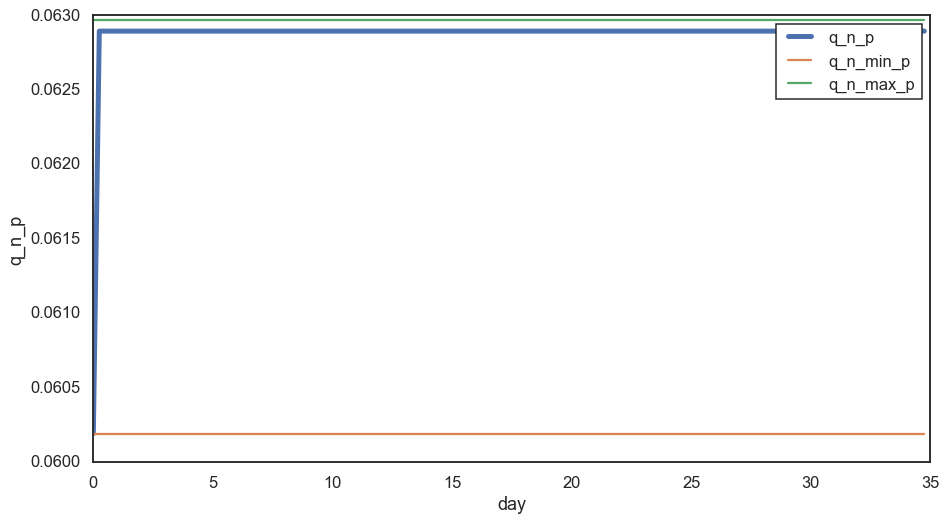

In [518]:
#sns.set_context('paper')
for i in [
     'q_n_p', #'q_n_a', 
       ]:
    sns.lineplot(data=res_df, x='day', y=i, label=i, lw=5)

for i in [
     'q_n_min_p', 'q_n_max_p', 
     #'q_n_min_a', 'q_n_max_a', 
       ]:
    sns.lineplot(data=res_df, x='day', y=m.get_param_val(i), label=i)
plt.legend(bbox_to_anchor=(1,1))
#plt.ylim(1e-10, 3e-9)
plt.show()

ValueError: Could not interpret input 'q_c_a'

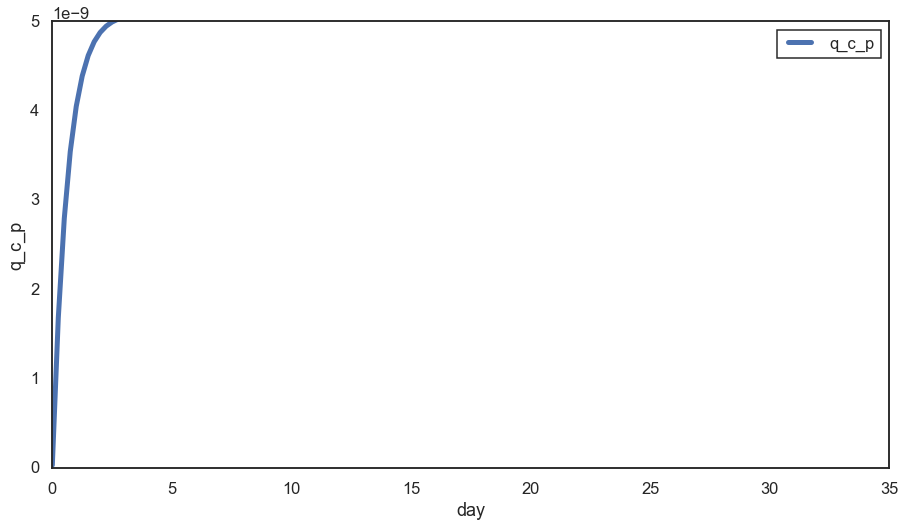

In [519]:
#sns.set_context('paper')
for i in [
     'q_c_p', 'q_c_a', 
       ]:
    sns.lineplot(data=res_df, x='day', y=i, label=i, lw=5)

for i in [
     'q_c_min_p', 'q_c_max_p', 
     'q_c_min_a', 'q_c_max_a', 
       ]:
    sns.lineplot(data=res_df, x='day', y=m.get_param_val(i), label=i)
plt.legend(bbox_to_anchor=(1,1))
plt.ylim(0, 7e-9)
plt.show()

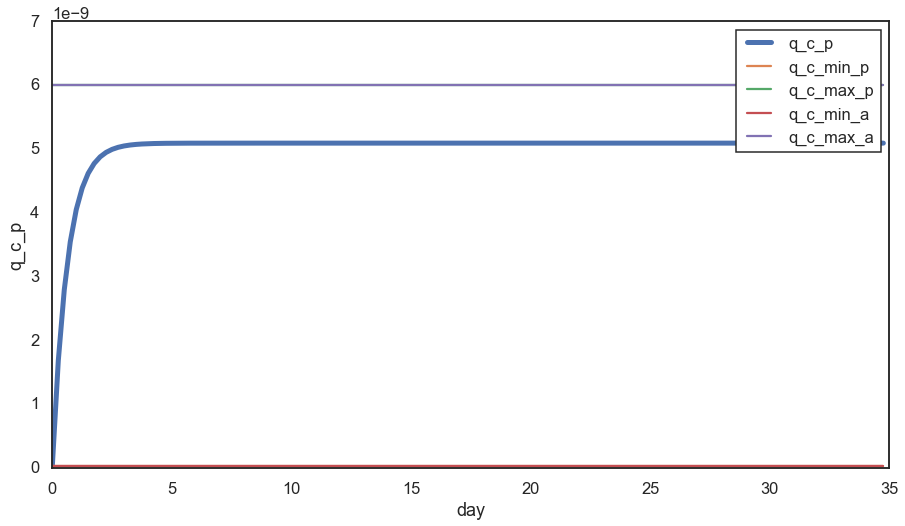

In [520]:
#sns.set_context('paper')
for i in [
     'q_c_p', #'q_c_a', 
       ]:
    sns.lineplot(data=res_df, x='day', y=i, label=i, lw=5)

for i in [
     'q_c_min_p', 'q_c_max_p', 
     'q_c_min_a', 'q_c_max_a', 
       ]:
    sns.lineplot(data=res_df, x='day', y=m.get_param_val(i), label=i)
plt.legend(bbox_to_anchor=(1,1))
plt.ylim(0, 7e-9)
plt.show()

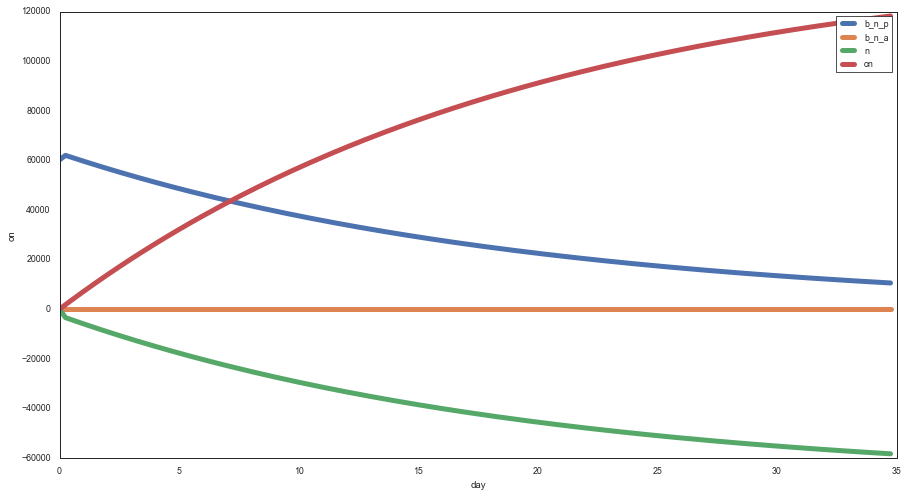

In [521]:
sns.set_context('paper')
for i in [
    'b_n_p', 'b_n_a',  'n', 'on',
       #'delta_b_n_p_uptake', 'delta_b_n_p_mortality', 'delta_b_n_p_excretion',
       #'delta_b_n_a_uptake', 'delta_b_n_a_mortality', 'delta_b_n_a_excretion',
       ]:
    sns.lineplot(data=res_df, x='day', y=i, label=i, lw=5)
plt.legend(bbox_to_anchor=(1,1))
#plt.yscale('log')
#plt.ylim(0,200)
plt.show()

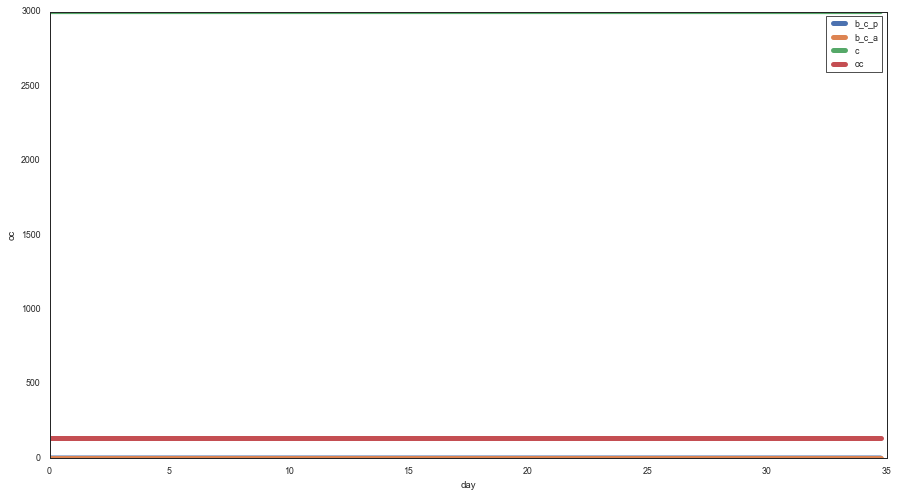

In [522]:
sns.set_context('paper')
for i in [
    'b_c_p', 'b_c_a',  'c', 'oc',
       #'delta_b_n_p_uptake', 'delta_b_n_p_mortality', 'delta_b_n_p_excretion',
       #'delta_b_n_a_uptake', 'delta_b_n_a_mortality', 'delta_b_n_a_excretion',
       ]:
    sns.lineplot(data=res_df, x='day', y=i, label=i, lw=5)
plt.legend(bbox_to_anchor=(1,1))
#plt.yscale('log')
#plt.ylim(0,200)
plt.show()

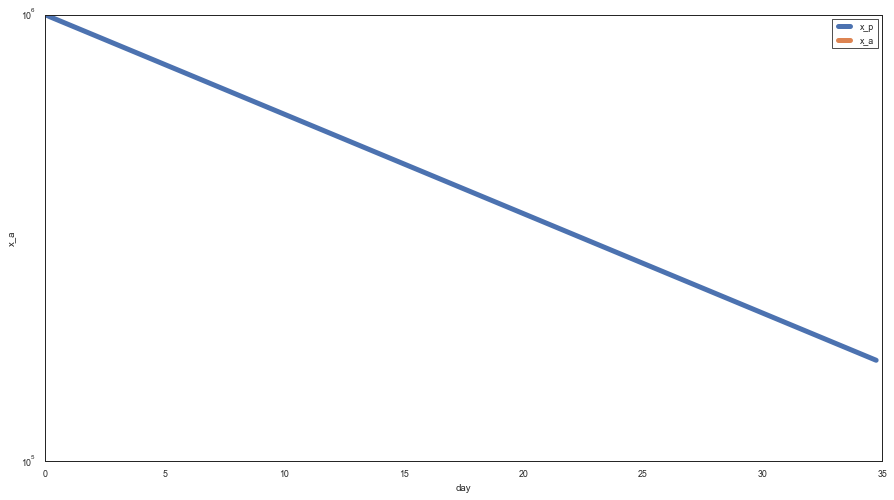

In [523]:
sns.set_context('paper')
for i in [
    'x_p', 'x_a',#  'c', 'oc',
       #'delta_b_n_p_uptake', 'delta_b_n_p_mortality', 'delta_b_n_p_excretion',
       #'delta_b_n_a_uptake', 'delta_b_n_a_mortality', 'delta_b_n_a_excretion',
       ]:
    sns.lineplot(data=res_df, x='day', y=i, label=i, lw=5)
plt.legend(bbox_to_anchor=(1,1))
plt.yscale('log')
#plt.ylim(0,200)
plt.show()

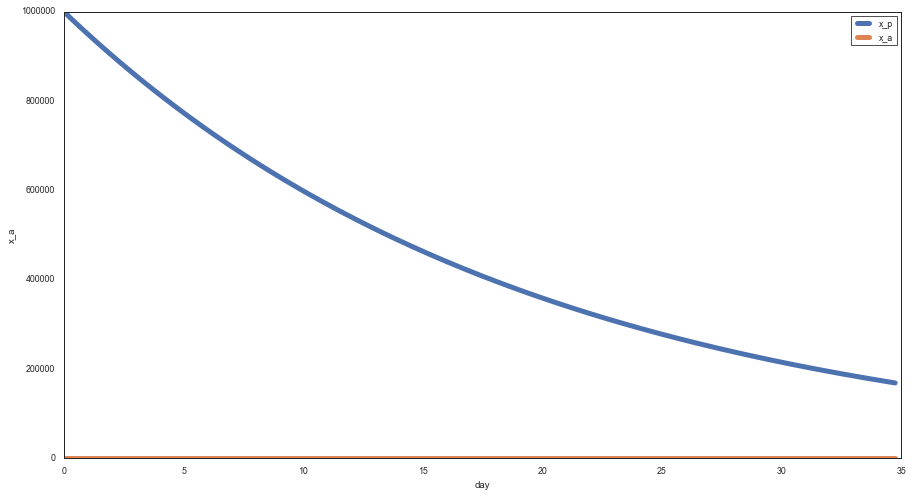

In [524]:
sns.set_context('paper')
for i in [
    'x_p', 'x_a',#  'c', 'oc',
       #'delta_b_n_p_uptake', 'delta_b_n_p_mortality', 'delta_b_n_p_excretion',
       #'delta_b_n_a_uptake', 'delta_b_n_a_mortality', 'delta_b_n_a_excretion',
       ]:
    sns.lineplot(data=res_df, x='day', y=i, label=i, lw=5)
plt.legend(bbox_to_anchor=(1,1))
#plt.yscale('log')
#plt.ylim(0,200)
plt.show()

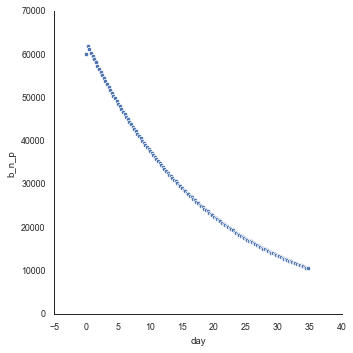

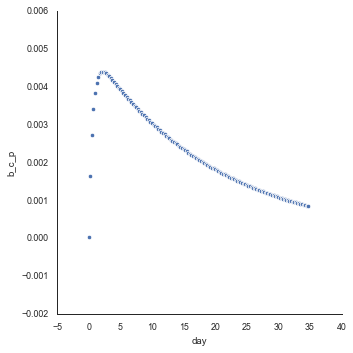

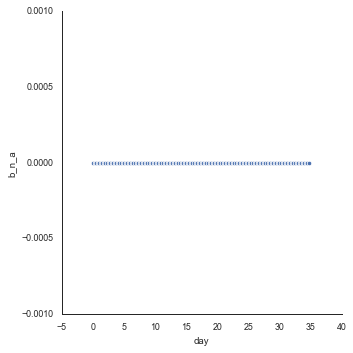

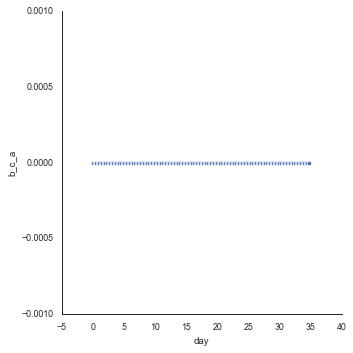

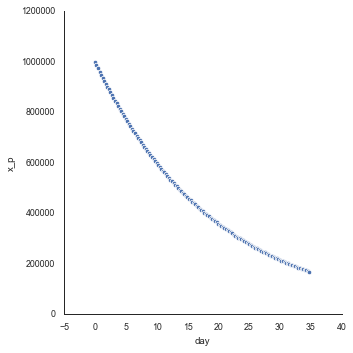

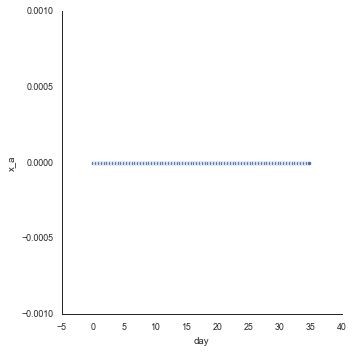

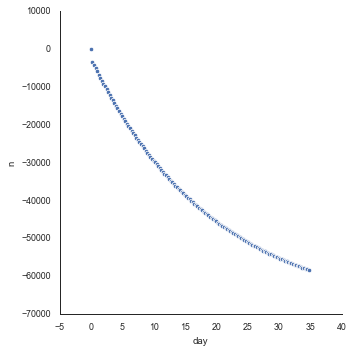

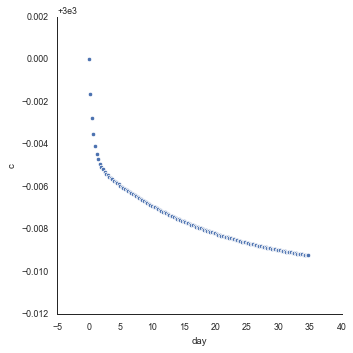

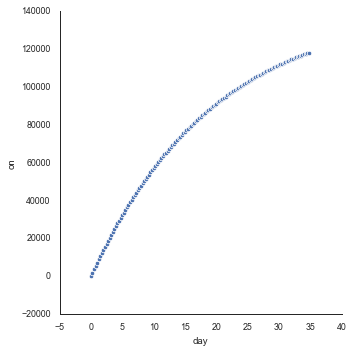

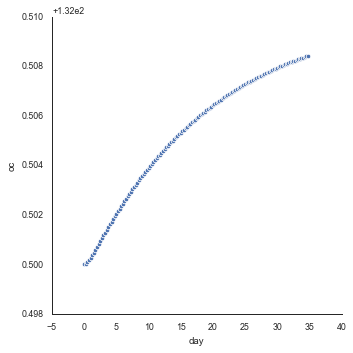

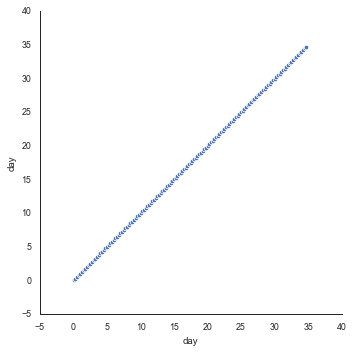

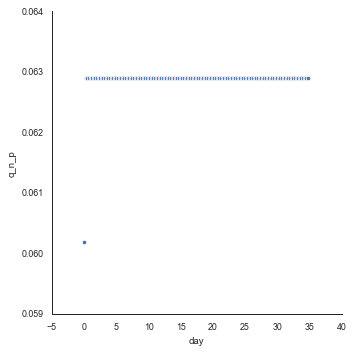

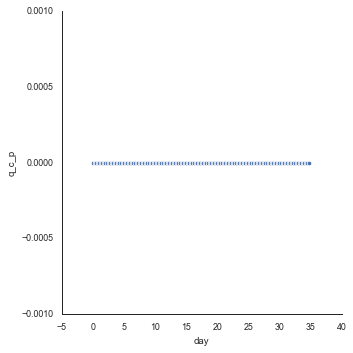

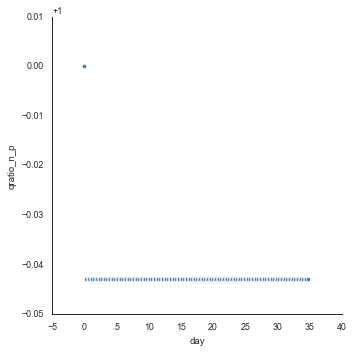

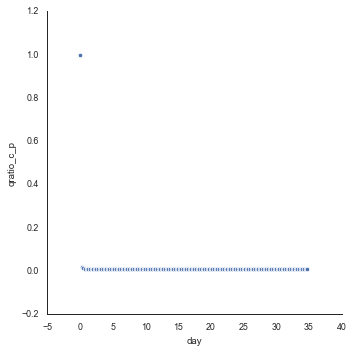

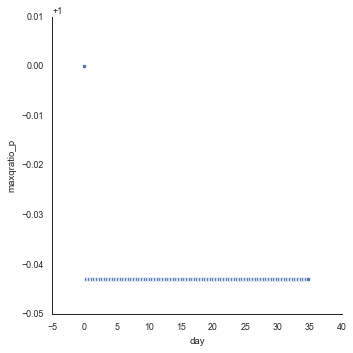

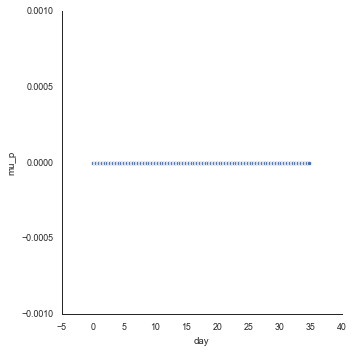

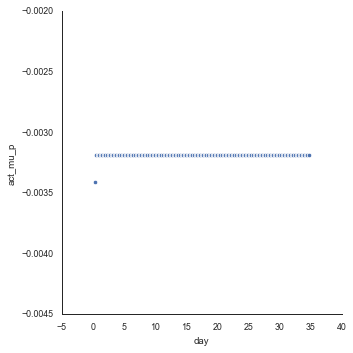

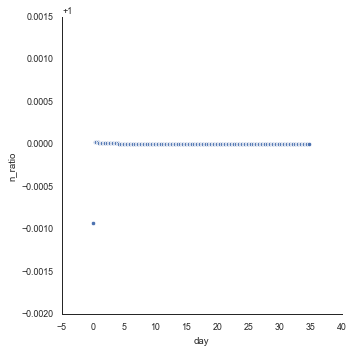

In [525]:
for i in res_df.columns:
    sns.relplot(data=res_df, x='day', y=i)

In [396]:
res_df.loc[res_df.oc <0].head()

,b_n_p,b_c_p,b_n_a,b_c_a,x_p,x_a,n,c,on,oc,day,q_n_p,q_c_p,qratio_n_p,qratio_c_p,maxqratio_p,mu_p,act_mu_p,n_ratio


In [397]:
res_df.loc[res_df.n <0].head()

,b_n_p,b_c_p,b_n_a,b_c_a,x_p,x_a,n,c,on,oc,day,q_n_p,q_c_p,qratio_n_p,qratio_c_p,maxqratio_p,mu_p,act_mu_p,n_ratio


In [398]:
res_df.tail()

,b_n_p,b_c_p,b_n_a,b_c_a,x_p,x_a,n,c,on,oc,day,q_n_p,q_c_p,qratio_n_p,qratio_c_p,maxqratio_p,mu_p,act_mu_p,n_ratio
135,21.544338,70.137045,0.0,0.0,1.679059e+10,0,70.604617,2904.302859,28.592476,158.060126,33.75,1.283120e-09,4.177164e-09,0.545545,0.007182,0.545545,1.363364e-11,0.018854,0.998443
136,23.168995,75.426560,0.0,0.0,1.805686e+10,0,68.387769,2897.085478,29.240533,159.987992,34.00,1.283113e-09,4.177168e-09,0.545548,0.007182,0.545548,1.363355e-11,0.018854,0.998393
137,24.916133,81.114951,0.0,0.0,1.941862e+10,0,66.003785,2889.323829,29.937459,162.061250,34.25,1.283105e-09,4.177173e-09,0.545552,0.007182,0.545552,1.363345e-11,0.018854,0.998335
138,26.794974,87.232286,0.0,0.0,2.088306e+10,0,63.440075,2880.976879,30.686939,164.290865,34.50,1.283096e-09,4.177179e-09,0.545555,0.007182,0.545555,1.363334e-11,0.018854,0.998268
139,28.815433,93.810899,0.0,0.0,2.245792e+10,0,60.683103,2872.000504,31.492934,166.688627,34.75,1.283086e-09,4.177185e-09,0.545560,0.007182,0.545560,1.363320e-11,0.018853,0.998189


In [399]:
m.get_param_val('delta_t')

1.1574074074074073e-05

In [400]:
1/(3600*24)

1.1574074074074073e-05

In [401]:
2.594074e+11 * m.get_param_val('delta_t') * m.get_param_val('delta_t')

34.75000535836762

In [527]:
ref_res_df = pd.DataFrame(refres)

In [528]:
ref_res_df

,b_n_p,b_c_p,b_n_a,b_c_a,x_p,x_a,n,c,on,oc,day
0,41691.636169,0.003375,0.0,0.0,662883.958152,0,-25105.636161,2999.993446,47846.546648,132.503209,8.0
1,35746.707959,0.002894,0.0,0.0,568361.461904,0,-31449.181453,2999.992932,61294.310105,132.504204,11.0
2,32262.211000,0.002612,0.0,0.0,512959.051663,0,-35167.319514,2999.992631,69176.438995,132.504787,13.0
3,29117.373807,0.002357,0.0,0.0,462957.125260,0,-38523.023041,2999.992360,76290.238275,132.505313,15.0
4,24965.445120,0.002021,0.0,0.0,396942.759448,0,-42953.345107,2999.992001,85682.135326,132.506008,18.0
5,22531.877843,0.001824,0.0,0.0,358249.801855,0,-45550.086896,2999.991791,91187.001853,132.506415,20.0
6,20335.528429,0.001646,0.0,0.0,323328.534001,0,-47893.704980,2999.991601,96155.268171,132.506783,22.0
7,17435.827890,0.001411,0.0,0.0,277224.203505,0,-50987.834970,2999.991351,102714.554411,132.507268,25.0
8,14949.603851,0.001210,0.0,0.0,237694.019853,0,-53640.764204,2999.991136,108338.533465,132.507684,28.0
9,14202.301285,0.001150,0.0,0.0,225812.143067,0,-54438.174570,2999.991071,110028.974032,132.507809,29.0


In [529]:
m.reference_iterations

{691200,
 950400,
 1123200,
 1296000,
 1555200,
 1728000,
 1900800,
 2160000,
 2419200,
 2505600,
 2764800,
 2937600}

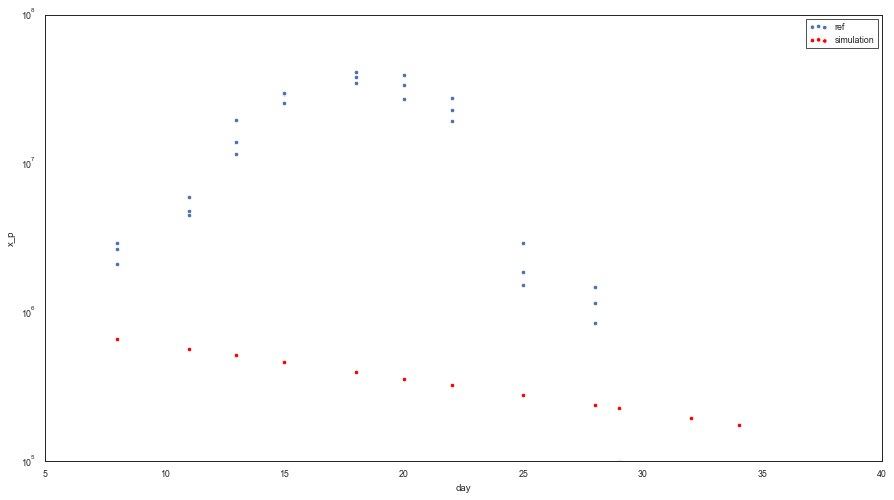

In [530]:
sns.scatterplot(x=fcm_dfn.loc[fcm_dfn.PRO== 'MIT9313'].day,
                y =fcm_dfn.loc[fcm_dfn.PRO== 'MIT9313'].VALUE, label='ref')
sns.scatterplot(x=ref_res_df.day, y=ref_res_df.x_p, label='simulation', color='red')
plt.yscale('log')

In [531]:
t = pd.merge(res_df[['day', 'x_p']], fcm_dfn.loc[fcm_dfn.PRO== 'MIT9313', ['day', 'VALUE']], on='day')
metrics.mean_squared_log_error(t['VALUE'], t['x_p'])


20.99685520996328

In [532]:
t

,day,x_p,VALUE
0,8.0,662883.958152,2.115254e+06
1,8.0,662883.958152,2.917191e+06
2,8.0,662883.958152,2.657627e+06
3,11.0,568361.461904,4.784504e+06
4,11.0,568361.461904,5.952542e+06
5,11.0,568361.461904,4.513317e+06
6,13.0,512959.051663,1.158547e+07
7,13.0,512959.051663,1.972107e+07
8,13.0,512959.051663,1.384019e+07
9,15.0,462957.125260,2.935981e+07


In [ ]:
def model_optimize_PRO(param_values, ref_df):
    m = ModelProALT()
    m.disable_organism('ALT')
    m.override_initial_values({
        'b_n_a': 0,
        'b_c_a': 0,
        'x_a': 0,
    })
    m.set_referece_times([0,0.5,0.6])
    _, ref_res = m.simulate(num_iterations=1*3600*24)

    t = pd.merge(res_df[['day', 'x_p']], fcm_dfn.loc[fcm_dfn.PRO== 'MIT9313', ['day', 'VALUE']], on='day')
    metrics.mean_squared_log_error(t['VALUE'], t['x_p'])
